## Credit Card Fraud Detection Project
### Project Summary
This project aims to train a classifier that can robustly detect fraudulent credit card transactions
### Dataset
An open source dataset containing credit card transactions from European cardholders in September 2013.

### Notes:
- The dataset is unbalanced and only contains 0.172% fraudulent transactions


- The dataset is anonymised and transformed into PCA data, original features are confidential

- Features V1, ..., V28 = PCA, 29 = Transaction Amount, 30 = Class Label 

- Users are recommended to use Area Under the Precision-Recall Curve (AUPRC) to improve accuracy due to issues from the imbalanced dataset  

### Acknowledgements
This project was completed with help from a tutorial by Pranjal Saxena found __[here](https://towardsdatascience.com/credit-card-fraud-detection-using-machine-learning-python-5b098d4a8edc)__

### 1. Necessary library imports


In [6]:
#Packages related to general operating system & warnings
import os 
import warnings
warnings.filterwarnings('ignore')
#Packages related to data importing, manipulation, exploratory data #analysis, data understanding
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from termcolor import colored as cl # text customization
#Packages related to data visualizaiton
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#Setting plot sizes and type of plot
plt.rc("font", size=14)
plt.rcParams['axes.grid'] = True
plt.figure(figsize=(6,3))
plt.gray()
from matplotlib.backends.backend_pdf import PdfPages
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import  PolynomialFeatures, KBinsDiscretizer, FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, OrdinalEncoder
import statsmodels.formula.api as smf
import statsmodels.tsa as tsa
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, export_text
from sklearn.ensemble import BaggingClassifier, BaggingRegressor,RandomForestClassifier,RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor, AdaBoostClassifier, AdaBoostRegressor 
from sklearn.svm import LinearSVC, LinearSVR, SVC, SVR
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Dataset import
data = pd.read_csv("creditcard.csv")

<Figure size 600x300 with 0 Axes>

### 2. Investigating the distribution of data (bisaed towards clean transactions)

In [7]:
Total_transactions = len(data)
normal = len(data[data.Class == 0])
fraudulent = len(data[data.Class == 1])
fraud_percent = round(fraudulent/normal*100, 2)
print(cl('Total num of transactions: {}'.format(Total_transactions)))
print(cl('Total num of normal transactions: {}'.format(normal)))
print(cl('Total num of fraudulent transactions: {}'.format(fraudulent)))
print(cl('Percentage of fraudulent transactions: {}'.format(fraud_percent)))


Total num of transactions: 284807
Total num of normal transactions: 284315
Total num of fraudulent transactions: 492
Percentage of fraudulent transactions: 0.17


### 3. Scaling and Preparing Data

- Feature 29, the transaction amount, has a significantly large range. This would affect the classifier results so the variable will be scaled. Scaling the variable will reduce the range, while preserving the spread of data.

- Notes on the scaling process: A StandardScaler() is used with the fit_transform() function. When scaling data with a Scikit-learn StandardScaler(), you can either use the fit_transform() or the transform() method. fit_transform() is used on training data, and calculates the mean and variance of each feature to center and scale the data. transform() however uses the pre-calculated feature mean and variances to scale test data, keeping the test data consistent with the training set.

- Feature 0 is dropped from the data set as it isn't a useful feature for the models.

- Duplicate transactions are removed to improve model efficiency

In [8]:
# Scale the 'amount' feature
sc = StandardScaler()
amount = data['Amount'].values
data['Amount'] = sc.fit_transform(amount.reshape(-1, 1))

# Drop the 'time' feature
data.drop(['Time'], axis=1, inplace=True)

# Drop any duplicate transactions
data.drop_duplicates(inplace=True)

### 4. Splitting the data into Train & Test sets

Models are trained on a subset of the data, known as the train data. Model performance is then evaluated using the test data to assess accuracy.

- First the independent (main feature data) and dependent (class values) variables are separated, then the data is split into corresponding test and train sets. Performing the split in one line of code ensures the data and class labels remain consistent.  

In [9]:
# Separate out the data and class labels
pure_data = data.drop('Class', axis = 1).values
labels = data['Class'].values

# Split the data and labels into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(pure_data, labels, test_size=0.25, random_state=1)

### 5.1. Model 1: Decision Tree

A desicion tree classifier is a form of supervised machine learning that uses a rule-based approach to make classification decisions.

The feature space is continually broken down into sets of rules until rules/data points run out. This results in a decision tree where each node corresponds to a class in the feature space. All pure leaf nodes (ones at the deepest layer of the tree that don't split data further) should be assigned to one class. In cases of mixed leaf nodes where the data points have varying classes, the most common class is selected.

The final tree won't be fully optimised as this is an NP-hard problem, instead a greedy approach is used. At each split, the algorithm tries to divide the dataset into the smallest possible subset and minimise the loss function.

#### Model performance: 

- Decision trees are prone to overfitting. By splitting the feature space until pure leaf nodes are reached, you can end up with a large tree that's too complex. The opposite can also happen where a tree ends up too small and underfits the data. 

- Decision trees aren't robust. Small changes in the data can drastically effect the produced tree, and the models performance

In [14]:
# Initialise the model with Scikit-learn
DT = DecisionTreeClassifier(max_depth = 4, criterion = 'entropy')

# Fit the model to the train data
DT.fit(train_data, train_labels)

# Run the model on the test data
dt_yhat = DT.predict(test_data)

# Evaluate the model performance
print('Accuracy score of the Decision Tree model: {}'.format(accuracy_score(test_labels, dt_yhat)))

# Evaluate the F1 score of the model
    # Standard accuracy isn't a good representaion if the dataset is class-unbalanced
    # F1 score combines model precision & recall for a more accurate performance assessment 
print('F1 score of the Decision Tree model: {}'.format(f1_score(test_labels, dt_yhat)))

# Print the confusion matrix
confusion_matrix(test_labels, dt_yhat, labels=[0,1])

Accuracy score of the Decision Tree model: 0.9991729061466132
F1 score of the Decision Tree model: 0.7574468085106382


array([[68770,    18],
       [   39,    89]], dtype=int64)

### 5.2. Model 2: K-Nearest Neighbour

A K-Nearest Neighbour classifier compares a given row of test data to the known training set. The k most similar rows of train data are selected, and their class mode is computed. The modal class is then assigned to the test data sample.

Varying the value of k can effect the classifier's performance, and can be seen through manual experimentation.

In [16]:
# Initialising the classifier, setting k=7
k = 7
KNN = KNeighborsClassifier(n_neighbors=k)

# Fit the train data to the model
KNN.fit(train_data, train_labels)

# Run the model on the test data
knn_yhat = KNN.predict(test_data)

# Calculate the model performance 
print('Accuracy score of the K-Nearest Neighbors model: {}'.format(accuracy_score(test_labels, knn_yhat)))
print('F1 score of the K-Nearest Neighbors model: {}'.format(f1_score(test_labels, knn_yhat)))

Accuracy score of the K-Nearest Neighbors model: 0.999288989494457
F1 score of the K-Nearest Neighbors model: 0.7949790794979079


### 5.3. Model 3: Logistic Regression

Logistic regression is a form of supervised learning predicts discrete outcomes (yes/no, 0/1, true/false, etc) from data. Data is converted to a probablistic value between 0 and 1 using a logistic function, and a class variable is assigned based on a threshold.

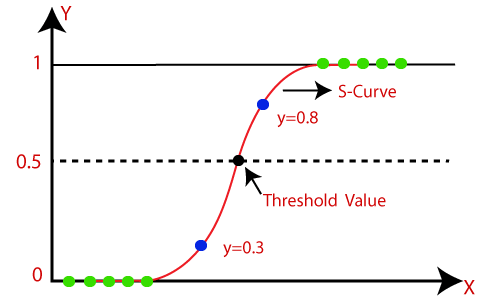

Image Desc: The graph shows a logistic (sigmoid) function used to calculate the probablistic value of data  

In [17]:
# Initialise the classifier
lr = LogisticRegression()

# Fit the model to the train data
lr.fit(train_data, train_labels)

# Run the model on the test data
lr_yhat = lr.predict(test_data)

# Check the accuracy of the model
print('Accuracy score of the K-Nearest Neighbors model: {}'.format(accuracy_score(test_labels, lr_yhat)))
print('F1 score of the K-Nearest Neighbors model: {}'.format(f1_score(test_labels, lr_yhat)))

Accuracy score of the K-Nearest Neighbors model: 0.9989552498694062
F1 score of the K-Nearest Neighbors model: 0.6666666666666666
